## Библиотеки, параметры, константы задачи

In [1]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="uvych_matrix_noise_predictor_1", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cpu")


## Загрузка данных

In [2]:
import torchvision

transforms = torchvision.transforms.Compose([
        torchvision.transforms.CenterCrop(64),
        torchvision.transforms.Normalize(0.5, 0.5)
    ])

env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=4, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 64, 64), feature_name="Uvych2_noised_re.xls", mapper=read_matrix, transform=transforms, lazy_load=True
    ) \
    .set_target(
        shape=(1, 64, 64), target_name="Uvych2_re.xls", mapper=read_matrix, transform=transforms, lazy_load=True
    ) \

print(env.train_count, env.val_count)

223 16


In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=24, val_batch_size=4
    ) \
    .load_feature(
        shape=(1, 80, 80), feature_name="Uvych2_noised_re_rotated.xls", mapper=read_matrix, transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_noise_only_re_rotated.xls", mapper=lambda path: read_matrix(path) * 1000., transform=None
    ) \

print(env.train_count, env.val_count)

37 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


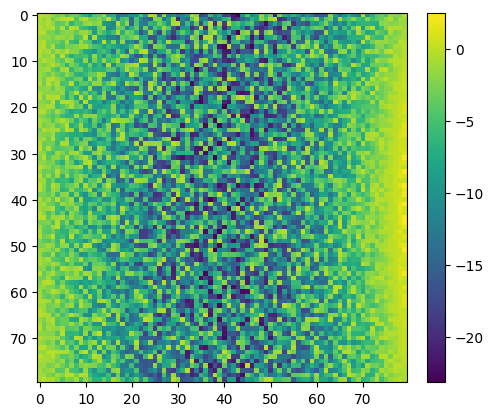

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(env.train_target_loader[0][0][0].cpu().detach().numpy())
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)


## Модели

### Новая локальная модель

In [29]:
env.set_name_model("uvych_matrix_noise_predictor_2")

In [5]:
env.model = models.autoencoders.UnetAutoencoder.UNetAuto(num_channels=1, num_out_channels=1).to(env.device)

In [26]:
env.model = models.autoencoders.unet.UNet(in_channels=1, out_channels=1, init_features=64).to(env.device)


In [4]:
env.model = models.autoencoders.residual.AEv5_0(in_channels=1, out_channels=1).to(env.device)
# fm_path="/home/amedvedev/projects/python/DenoisingCNN/assets/pt/uvych_matrix_denoiser_10 (4th copy).pt"
from torch import nn


AEv5_0(
  (conv0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose1): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose2): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_transpose3): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(

In [4]:
env.model = models.predictors.NoiseMatrixPredictor_v1(1, 1, 80, 80, 80 * 80).to(env.device)

In [26]:
from torch import nn
class UvychDimExpand(nn.Module):
    def __init__(self, in_channels, out_channels, width, height, hidden_size):
        super(UvychDimExpand, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.width = width
        self.height = height
        self.orig_size = width * height
        self.hidden_size = hidden_size

        self.ft = nn.Sequential(
            nn.Linear(self.orig_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
        )

        self.inv = nn.Linear(hidden_size, self.orig_size)

    def forward(self, x):
        bs = x.size()[0]
        x = x.view(bs, self.height * self.width)
        h = self.ft(x)
        x = self.inv(h)
        x = x.view(bs, self.out_channels, self.height, self.width)

        return x

env.model = UvychDimExpand(1, 1, 80, 80, 2048).to(env.device)



In [27]:
from torch import nn
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight.data)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02)
        nn.init.constant_(m.bias.data, 0)

env.model.apply(weights_init)

UvychDimExpand(
  (ft): Sequential(
    (0): Linear(in_features=6400, out_features=2048, bias=True)
    (1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=2048, out_features=2048, bias=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (inv): Linear(in_features=2048, out_features=6400, bias=True)
)

In [22]:
env.model = models.autoencoders.swin_unet.SwinTransformerSys(64, in_chans=1, num_classes=1, window_size=4).to(env.device)


SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:1
---final upsample expand_first---


In [4]:
env.model

AEv4_0(
  (first): AEv2_0(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose1): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_transpose3): ConvTranspose2d(64, 64, k

### Импорт претренерованной модели

In [6]:
env.load_model(model_type="pt")

## Визуализация батча валидационного датасета

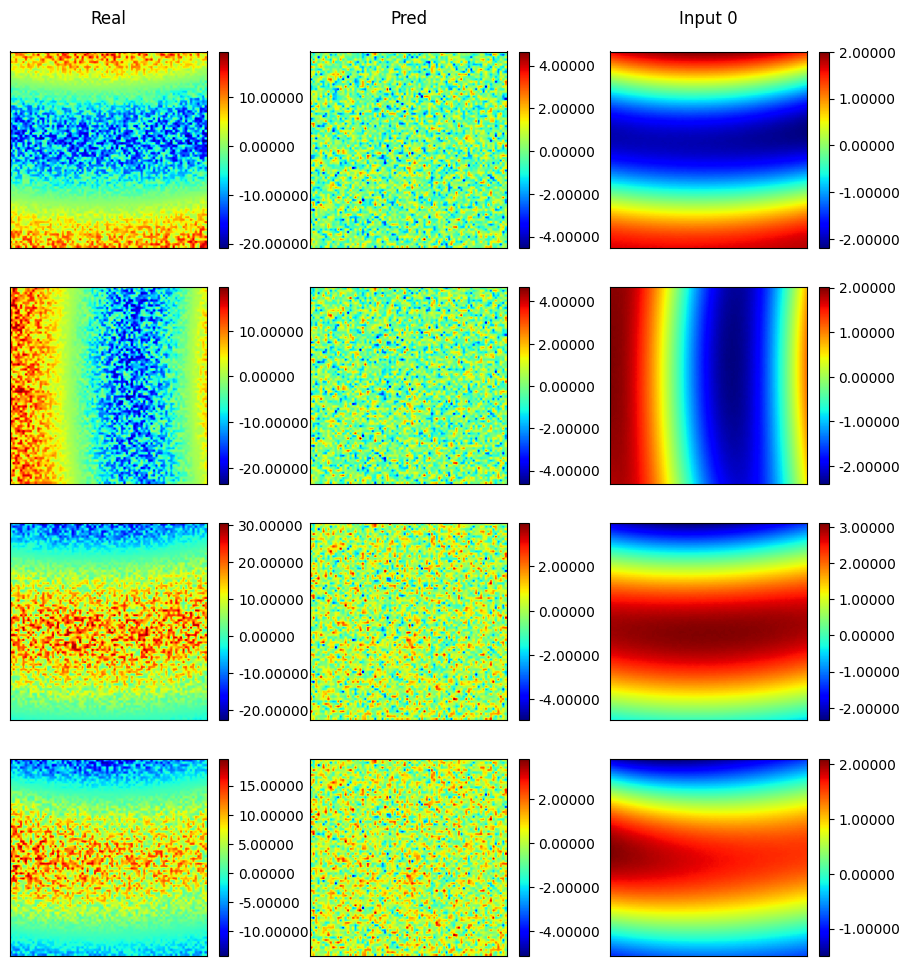

In [28]:
env.plot_batch_with_inputs(concrete=0, figsize=(10, 10), format="%.5f", wspace=0.0, hspace=0.2)


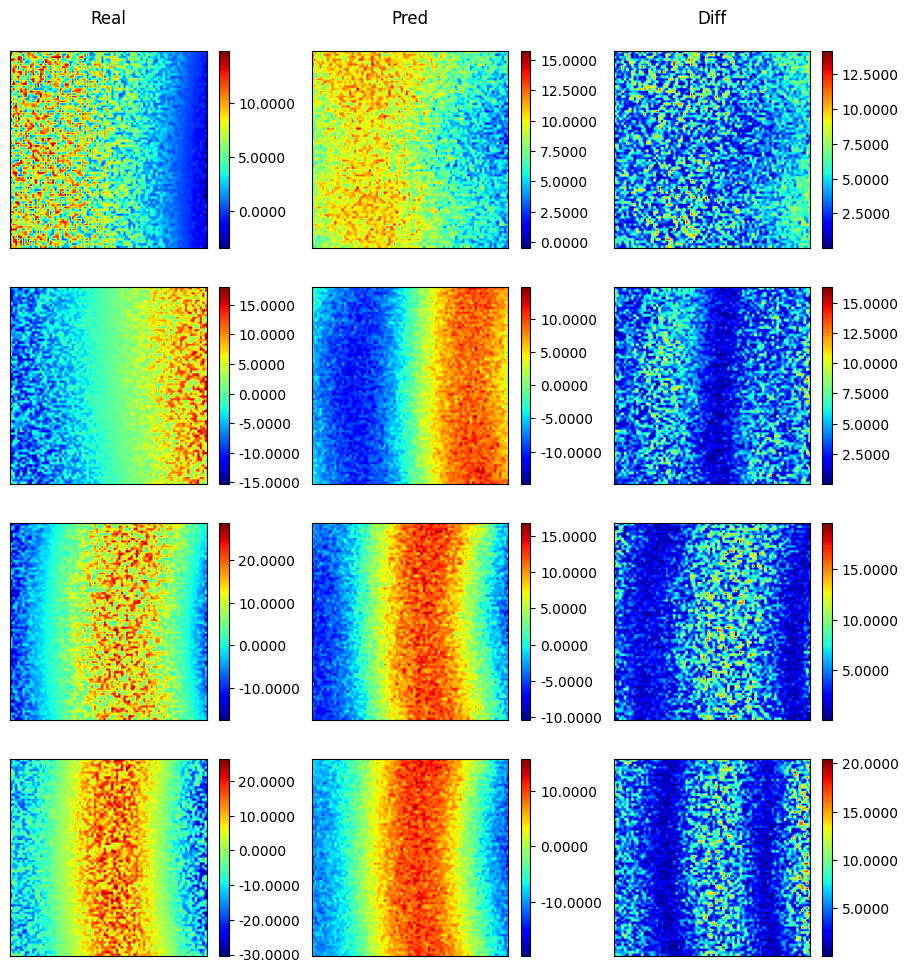

In [20]:
env.plot_batch(concrete=6, figsize=(10, 10), format="%.4f", wspace=0.0, hspace=0.2)


## Численные значения отклонений

In [31]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            
            for ex_id in range(env.val_batch_size):
                
                losses_dataset_step = torch.max(torch.abs(data_features[0][ex_id][0] - data_target[ex_id])).detach().tolist()
                losses_dataset.append(losses_dataset_step)
                
                init_error = torch.mean(torch.abs(data_features[0][ex_id][0] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                init_errors.append(init_error.detach().tolist())
                
                loss = torch.max(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())
                
                
                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / torch.abs(data_target[ex_id]))
                errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Начальная максимальная относительная ошибка:", max(init_errors))
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 24.60308377444744
Текущее среднее отклонение по значениям: 21.24265892803669

Начальное максимальное отклонение по значениям: 68.01959228515625
Текущее максимальное отклонение по значениям в векторе: 64.76018524169922

Начальная средняя относительная ошибка: 2.624696908518672
Текущая средняя относительная ошибка: 13.478894650936127

Начальная максимальная относительная ошибка: 54.08830261230469
Текущая максимальная относительная ошибка: 199.21444702148438


## Training

In [18]:
from common.losses import MseCoeffLoss, L1CoeffLoss
from pytorch_msssim import MS_SSIM as _MS_SSIM


In [24]:
env.set_name_model("uvych_tensor_denoiser_2")

In [13]:
opt = torch.optim.AdamW(env.model.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[int(10 * 0.6), int(10 * 0.9)], gamma=0.1)

In [16]:
class L1_MSSSIM(torch.nn.Module):
    def __init__(self):
        super(L1_MSSSIM, self).__init__()
        self.l1 = nn.L1Loss()
        self.ms_ssim = _MS_SSIM(data_range=4, size_average=True, win_size=1, channel=1)

    def forward(self, x, y):
        ms_ssim_loss = 1 - self.ms_ssim(x, y)
        l1_loss = self.l1(x, y)

        return l1_loss + ms_ssim_loss

In [12]:
from torch import nn

In [22]:
env.train(5, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=L1_MSSSIM().to(env.device), 
          callbacks=[lambda: scheduler.step()]) #


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.003264773 	Validating Loss: 0.003573360 	Time: 2.09 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.003263244 	Validating Loss: 0.003578866 	Time: 2.10 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.003261630 	Validating Loss: 0.003583670 	Time: 2.10 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	

In [29]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)


In [30]:
env.train(200, step_saving=True, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.MSELoss(reduction="none", reduce="none"), 
          callbacks=[lambda: scheduler.step(env.test_losses[-1])]) #lambda: scheduler.step(env.test_losses[-1])

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 56.021121360 	Validating Loss: 49.588369250 	Time: 0.16 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 44.879965808 	Validating Loss: 47.605193973 	Time: 0.16 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 43.679947106 	Validating Loss: 46.929005742 	Time: 0.17 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoc

KeyboardInterrupt: 

## Сохранение модели

In [19]:
env.save(onnx=False, pth=False)

## Loss visualisation

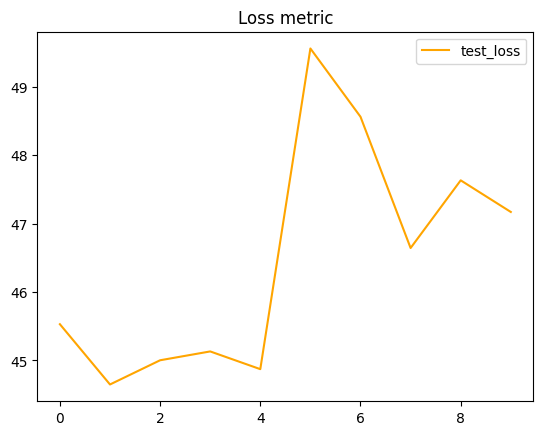

In [18]:
env.show_metrics(n_last=50, train=False, val=True)

## Clear memory

In [27]:
import gc
gc.collect()


42269

In [35]:
env.model.cpu()
del env.model
import torch
torch.cuda.empty_cache()